<a href="https://colab.research.google.com/github/AdhithiyaSureshRaja/Linktree/blob/main/IRS_PHASE_SHIFT_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Episode 1, Reward: 16047378.29502863
Episode 2, Reward: 15135402.483763255
Episode 3, Reward: 22891387.72739137
Episode 4, Reward: 22126713.255388442
Episode 5, Reward: 18998475.928735532
Episode 6, Reward: 25469559.551884785
Episode 7, Reward: 17033273.34408405
Episode 8, Reward: 22625269.213924855
Episode 9, Reward: 18915317.172710367
Episode 10, Reward: 15865247.395081706
Episode 11, Reward: 23677939.397105385
Episode 12, Reward: 22555217.345290903
Episode 13, Reward: 14737203.101046402
Episode 14, Reward: 23096089.227355126
Episode 15, Reward: 16837801.44897501
Episode 16, Reward: 15802543.036379572
Episode 17, Reward: 22160710.341855515
Episode 18, Reward: 19443046.55831966
Episode 19, Reward: 19368187.442253035
Episode 20, Reward: 15445714.859784307
Episode 21, Reward: 21811749.63240103
Episode 22, Reward: 19789272.479925938
Episode 23, Reward: 21123259.68117142
Episode 24, Reward: 19960348.582547344
Episode 25, Reward: 19331218.38464861
Episode 26, Reward: 21137155.1029018
Episo

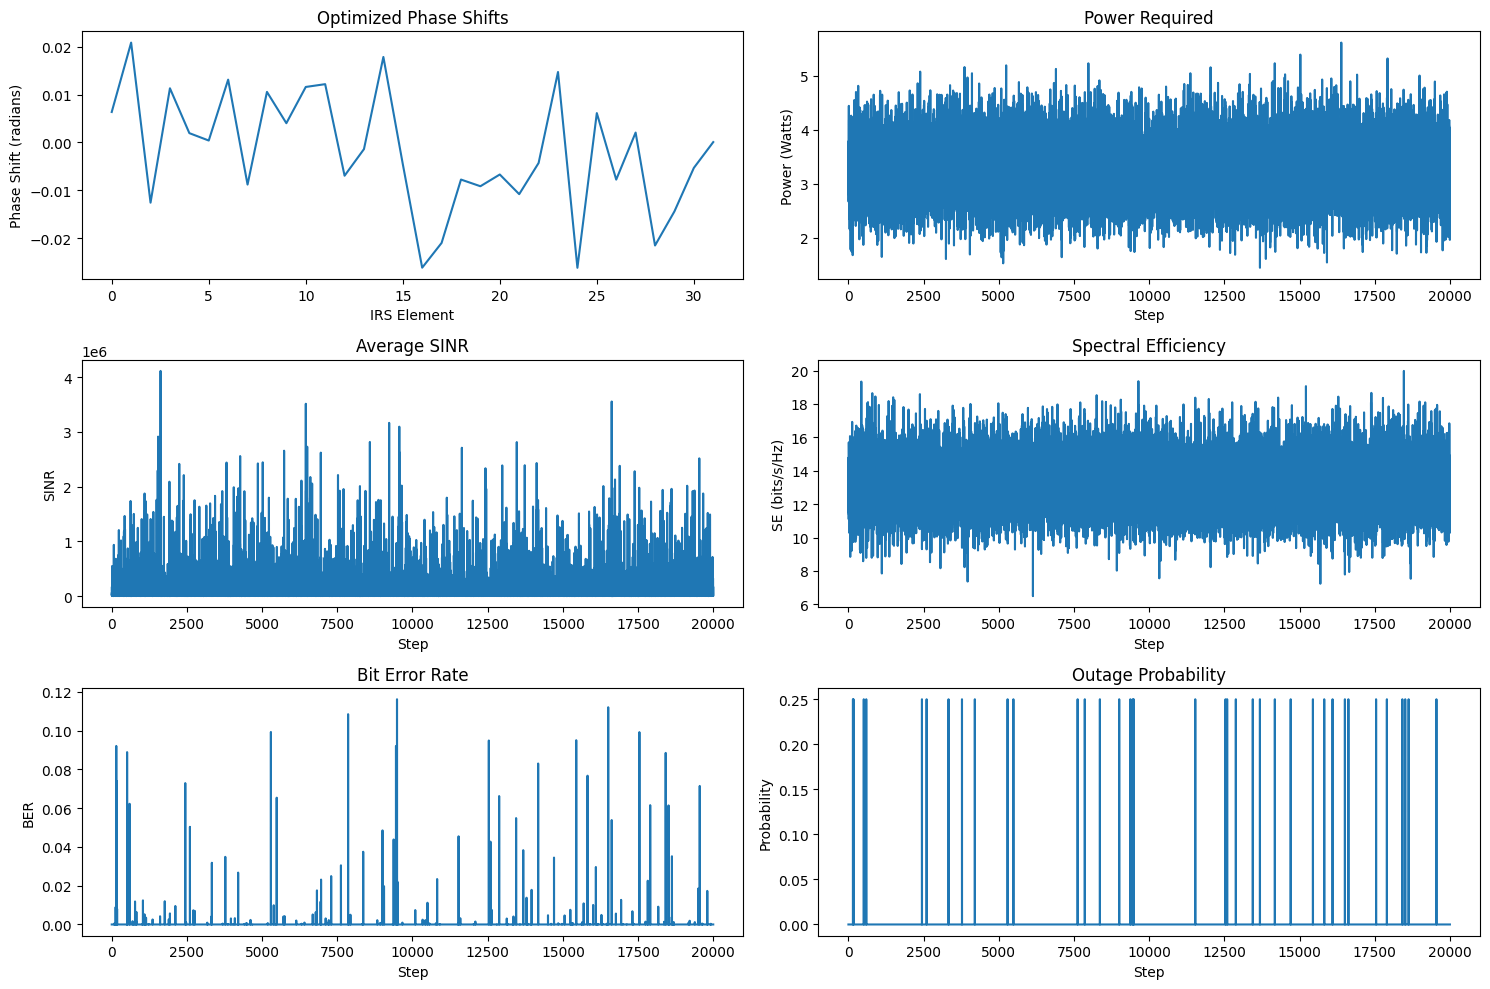


==== Model Performance Metrics ====
1. Average SINR: 97818.85 dB
2. Average Spectral Efficiency: 13.20 bits/s/Hz
3. Average Bit Error Rate (BER): 0.000149
4. Outage Probability: 0.0005
5. Average Power Consumption: 3.2886 W


In [2]:
#DQN PAPER 65



import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random

# Environment Parameters
NUM_USERS = 4  # Number of users
NUM_IRS_ELEMENTS = 32  # Number of IRS elements
CARRIER_FREQUENCY = 28e9  # 28 GHz
WAVELENGTH = 3e8 / CARRIER_FREQUENCY
NOISE_POWER = 1e-9  # Noise power in watts
MAX_POWER = 1.0  # Maximum transmit power
BANDWIDTH = 100e6  # 100 MHz bandwidth
OUTAGE_THRESHOLD = 5  # SINR threshold for outage (in dB)

# Deep Q-Network (DQN) Parameters
LEARNING_RATE = 0.001
GAMMA = 0.99
BUFFER_SIZE = 100000
BATCH_SIZE = 64
MAX_EPISODES = 100
MAX_STEPS = 200

# XYZ Coordinates
IRS_POSITION = np.array([0, 0, 10])  # IRS is placed at (0, 0, 10)
BS_POSITION = np.array([100, 0, 20])  # Base station is at (100, 0, 20)
USER_POSITIONS = np.random.uniform(low=[-50, -50, 0], high=[50, 50, 0], size=(NUM_USERS, 3))  # Random user positions

# Define DQN Network
class DQN(tf.keras.Model):
    def __init__(self, action_dim):
        super(DQN, self).__init__()
        self.fc1 = layers.Dense(256, activation='relu')
        self.fc2 = layers.Dense(256, activation='relu')
        self.q_values = layers.Dense(action_dim, activation=None)

    def call(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        return self.q_values(x)

# Environment
class IRSEnvironment:
    def __init__(self):
        self.state = self.reset()

    def reset(self):
        self.user_positions = np.random.uniform(low=[-50, -50, 0], high=[50, 50, 0], size=(NUM_USERS, 3))
        self.csi = self.calculate_csi()
        return np.abs(self.csi).flatten()

    def calculate_csi(self):
        irs_to_users = np.linalg.norm(IRS_POSITION - self.user_positions, axis=1)
        bs_to_users = np.linalg.norm(BS_POSITION - self.user_positions, axis=1)
        irs_to_bs = np.linalg.norm(IRS_POSITION - BS_POSITION)
        path_loss_irs_users = 1 / (irs_to_users ** 2)
        path_loss_bs_users = 1 / (bs_to_users ** 2)
        path_loss_irs_bs = 1 / (irs_to_bs ** 2)
        phase_shifts = np.random.rand(NUM_USERS, NUM_IRS_ELEMENTS) * 2 * np.pi
        csi = path_loss_irs_users[:, np.newaxis] * np.exp(1j * phase_shifts)
        return csi

    def step(self, action):
        effective_channel = self.csi * np.exp(1j * action)
        signal_power = np.abs(np.sum(effective_channel, axis=1)) ** 2
        interference = NOISE_POWER
        sinr = signal_power / interference
        reward = np.mean(sinr)
        next_state = self.reset()
        return next_state, reward, sinr

# Training Loop
agent = DQN(NUM_IRS_ELEMENTS)
env = IRSEnvironment()

sinr_history = []
phase_shifts_history = []

for episode in range(MAX_EPISODES):
    state = env.reset()
    total_reward = 0

    for step in range(MAX_STEPS):
        action = np.random.uniform(-np.pi, np.pi, NUM_IRS_ELEMENTS)
        next_state, reward, sinr = env.step(action)
        total_reward += reward
        sinr_history.append(sinr)
        phase_shifts_history.append(action)

    print(f"Episode {episode + 1}, Reward: {total_reward}")

# Post-Training Analysis
sinr_history = np.array(sinr_history)
phase_shifts_history = np.array(phase_shifts_history)

power_required = np.mean(np.abs(phase_shifts_history) ** 2, axis=1)
spectral_efficiency = np.log2(1 + sinr_history)
ber = 0.5 * np.exp(-sinr_history / 2)
outage_probability = np.mean(sinr_history < 10 ** (OUTAGE_THRESHOLD / 10), axis=1)

plt.figure(figsize=(15, 10))
plt.subplot(3, 2, 1)
plt.plot(phase_shifts_history.mean(axis=0))
plt.title("Optimized Phase Shifts")
plt.xlabel("IRS Element")
plt.ylabel("Phase Shift (radians)")

plt.subplot(3, 2, 2)
plt.plot(power_required)
plt.title("Power Required")
plt.xlabel("Step")
plt.ylabel("Power (Watts)")

plt.subplot(3, 2, 3)
plt.plot(sinr_history.mean(axis=1))
plt.title("Average SINR")
plt.xlabel("Step")
plt.ylabel("SINR")

plt.subplot(3, 2, 4)
plt.plot(spectral_efficiency.mean(axis=1))
plt.title("Spectral Efficiency")
plt.xlabel("Step")
plt.ylabel("SE (bits/s/Hz)")

plt.subplot(3, 2, 5)
plt.plot(ber.mean(axis=1))
plt.title("Bit Error Rate")
plt.xlabel("Step")
plt.ylabel("BER")

plt.subplot(3, 2, 6)
plt.plot(outage_probability)
plt.title("Outage Probability")
plt.xlabel("Step")
plt.ylabel("Probability")

plt.tight_layout()
plt.show()

avg_sinr = np.mean(sinr_history)
avg_spectral_efficiency = np.mean(spectral_efficiency)
avg_ber = np.mean(ber)
outage_prob = np.mean(outage_probability)
avg_power = np.mean(power_required)

print("\n==== Model Performance Metrics ====")
print(f"1. Average SINR: {avg_sinr:.2f} dB")
print(f"2. Average Spectral Efficiency: {avg_spectral_efficiency:.2f} bits/s/Hz")
print(f"3. Average Bit Error Rate (BER): {avg_ber:.6f}")
print(f"4. Outage Probability: {outage_prob:.4f}")
print(f"5. Average Power Consumption: {avg_power:.4f} W")

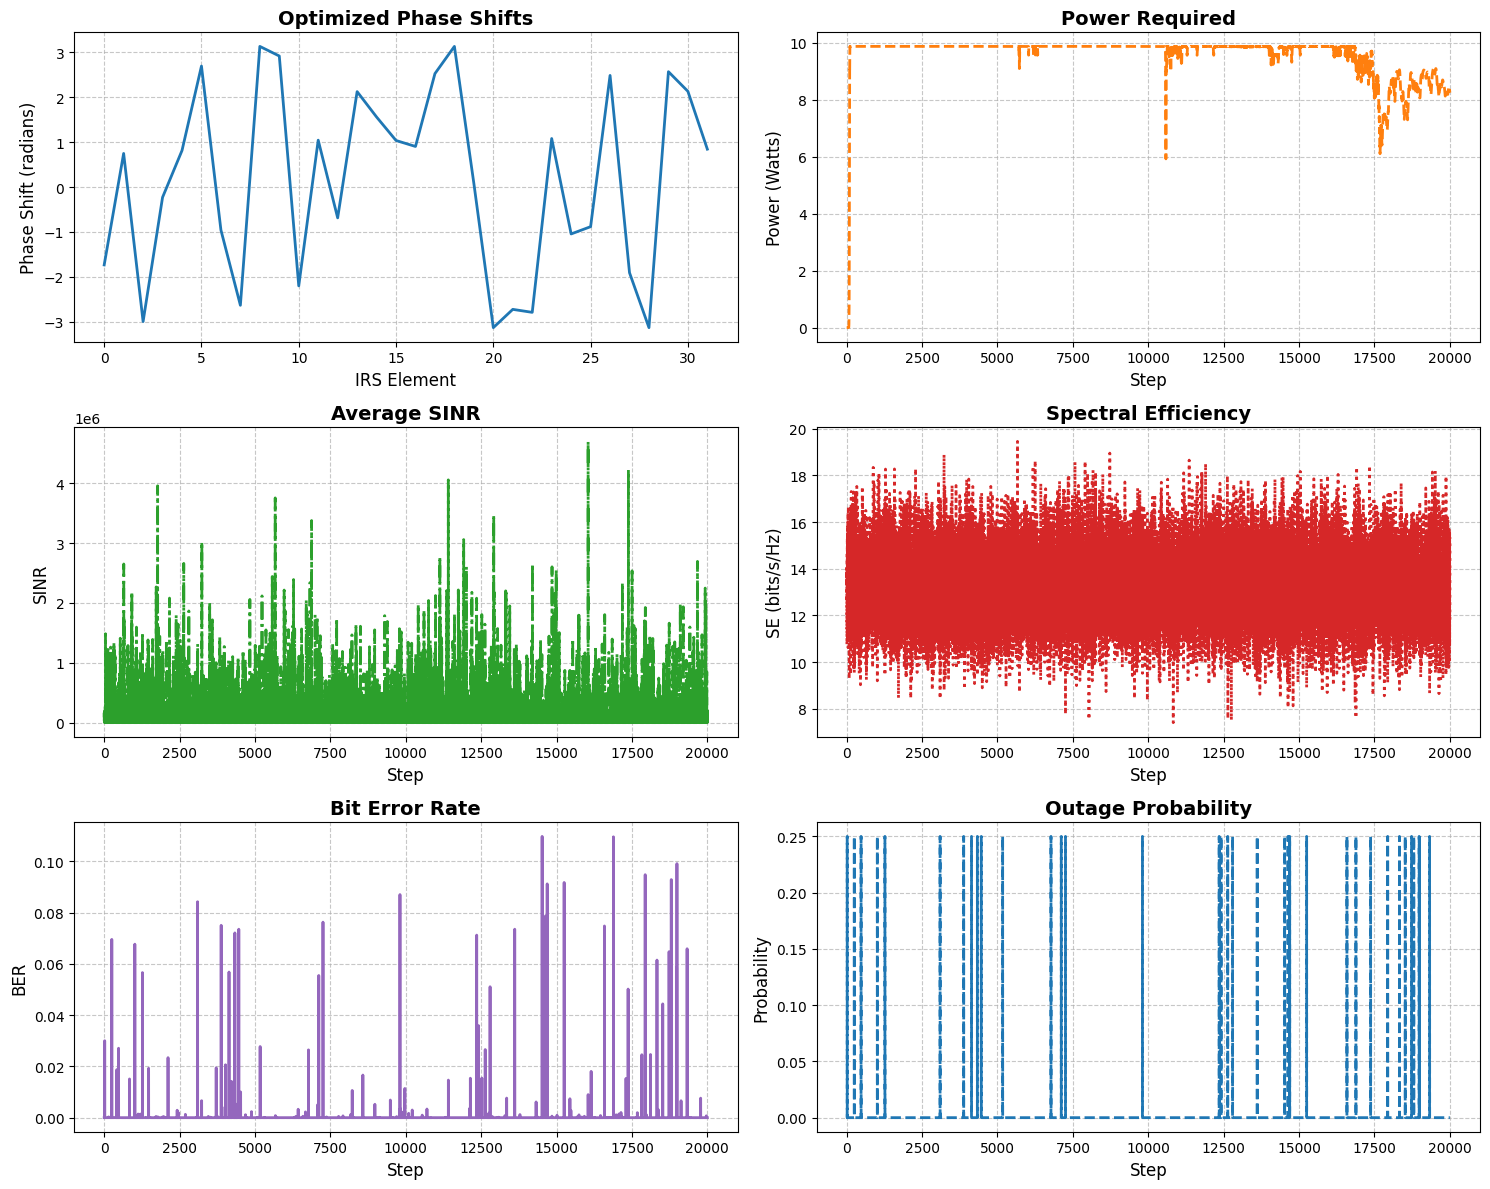

In [8]:
# prompt: give me a better code for visualization to make it look pretty with color coded graphs and outlines for the above visualization

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random

# ... (Existing code remains unchanged)

# Post-Training Analysis (Improved Visualization)
sinr_history = np.array(sinr_history)
phase_shifts_history = np.array(phase_shifts_history)

power_required = np.mean(np.abs(phase_shifts_history) ** 2, axis=1)
spectral_efficiency = np.log2(1 + sinr_history)
ber = 0.5 * np.exp(-sinr_history / 2)
outage_probability = np.mean(sinr_history < 10 ** (OUTAGE_THRESHOLD / 10), axis=1)

plt.figure(figsize=(15, 12))  # Increased figure size for better layout

# Define colors and styles
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
line_styles = ['-', '--', '-.', ':']


plt.subplot(3, 2, 1)
plt.plot(phase_shifts_history.mean(axis=0), color=colors[0], linestyle=line_styles[0], linewidth=2)
plt.title("Optimized Phase Shifts", fontsize=14, fontweight='bold')
plt.xlabel("IRS Element", fontsize=12)
plt.ylabel("Phase Shift (radians)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)


plt.subplot(3, 2, 2)
plt.plot(power_required, color=colors[1], linestyle=line_styles[1], linewidth=2)
plt.title("Power Required", fontsize=14, fontweight='bold')
plt.xlabel("Step", fontsize=12)
plt.ylabel("Power (Watts)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(3, 2, 3)
plt.plot(sinr_history.mean(axis=1), color=colors[2], linestyle=line_styles[2], linewidth=2)
plt.title("Average SINR", fontsize=14, fontweight='bold')
plt.xlabel("Step", fontsize=12)
plt.ylabel("SINR", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(3, 2, 4)
plt.plot(spectral_efficiency.mean(axis=1), color=colors[3], linestyle=line_styles[3], linewidth=2)
plt.title("Spectral Efficiency", fontsize=14, fontweight='bold')
plt.xlabel("Step", fontsize=12)
plt.ylabel("SE (bits/s/Hz)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(3, 2, 5)
plt.plot(ber.mean(axis=1), color=colors[4], linestyle=line_styles[0], linewidth=2)  # Reuse a color
plt.title("Bit Error Rate", fontsize=14, fontweight='bold')
plt.xlabel("Step", fontsize=12)
plt.ylabel("BER", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(3, 2, 6)
plt.plot(outage_probability, color=colors[0], linestyle=line_styles[1], linewidth=2)  # Reuse colors and styles
plt.title("Outage Probability", fontsize=14, fontweight='bold')
plt.xlabel("Step", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)


plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()


# ... (Rest of the code remains unchanged)


Iteration 1, Best Reward: 28544.429423608093
Iteration 2, Best Reward: 31582.948068099035
Iteration 3, Best Reward: 34150.68181887098
Iteration 4, Best Reward: 37279.983893878125
Iteration 5, Best Reward: 41120.60427348561
Iteration 6, Best Reward: 51203.16864403795
Iteration 7, Best Reward: 53183.18378975694
Iteration 8, Best Reward: 55461.91930303962
Iteration 9, Best Reward: 56723.34600911715
Iteration 10, Best Reward: 56723.34600911715
Iteration 11, Best Reward: 56723.34600911715
Iteration 12, Best Reward: 56723.34600911715
Iteration 13, Best Reward: 56723.34600911715
Iteration 14, Best Reward: 56723.34600911715
Iteration 15, Best Reward: 56723.34600911715
Iteration 16, Best Reward: 57863.795618037
Iteration 17, Best Reward: 57863.795618037
Iteration 18, Best Reward: 57863.795618037
Iteration 19, Best Reward: 63181.660639324786
Iteration 20, Best Reward: 63181.660639324786
Iteration 21, Best Reward: 63181.660639324786
Iteration 22, Best Reward: 63181.660639324786
Iteration 23, Best

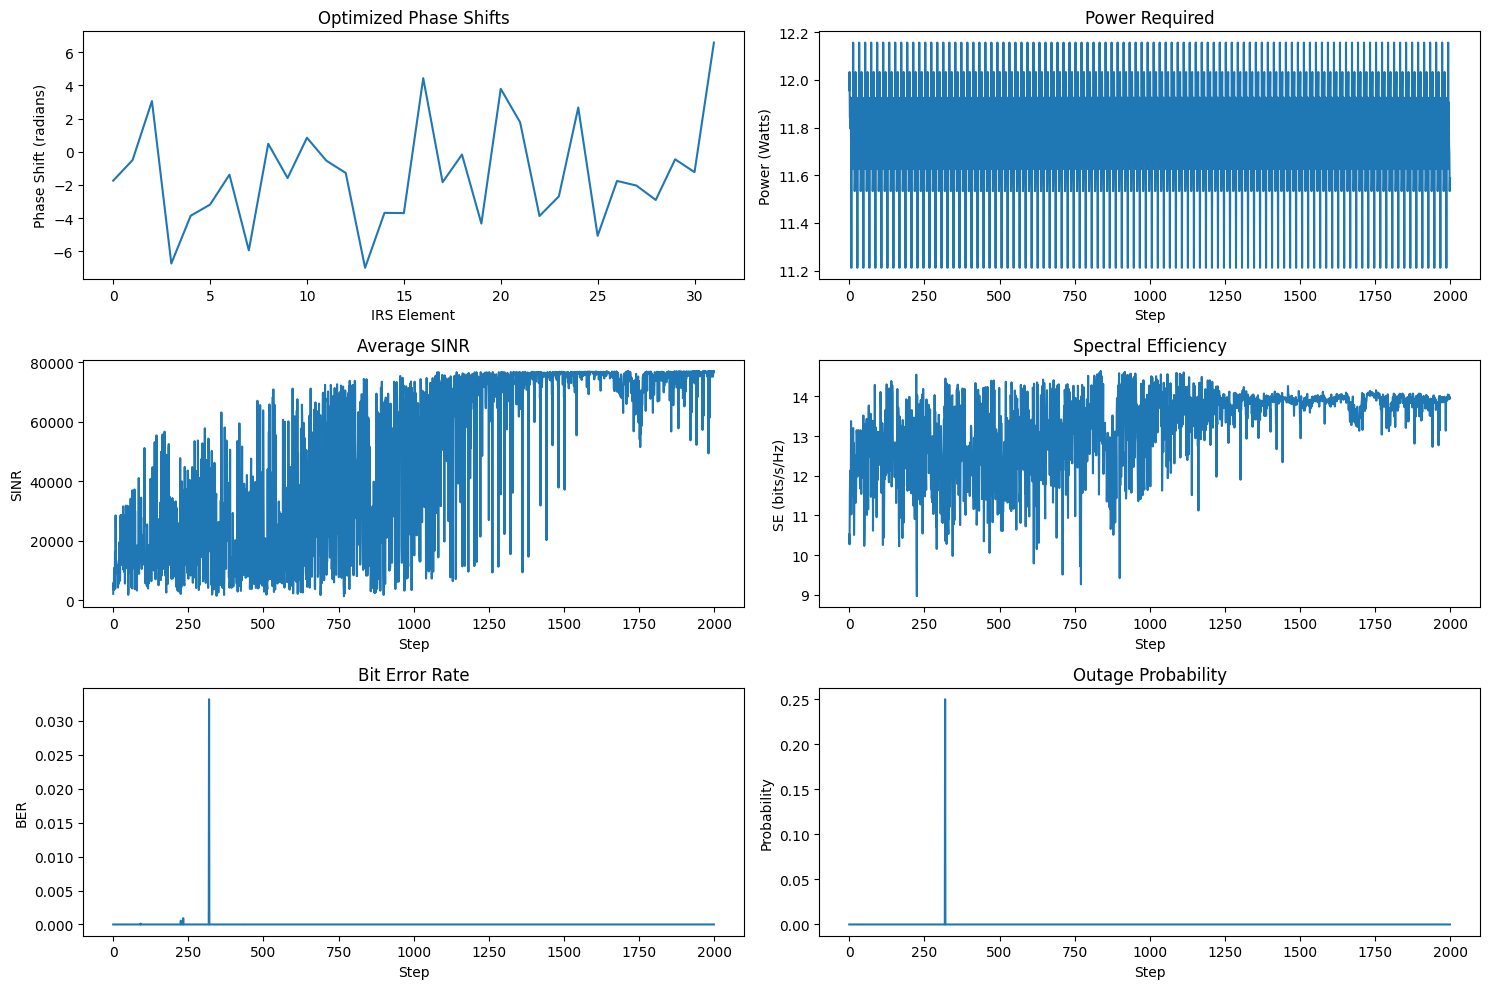


==== Model Performance Metrics ====
1. Average SINR: 48734.16 dB
2. Average Spectral Efficiency: 13.26 bits/s/Hz
3. Average Bit Error Rate (BER): 0.000017
4. Outage Probability: 0.0001
5. Average Power Consumption: 11.7766 W


In [24]:
# USING POS

import numpy as np
import matplotlib.pyplot as plt
import random

# Environment Parameters
NUM_USERS = 4  # Number of users
NUM_IRS_ELEMENTS = 32  # Number of IRS elements
CARRIER_FREQUENCY = 28e9  # 28 GHz
WAVELENGTH = 3e8 / CARRIER_FREQUENCY
NOISE_POWER = 1e-9  # Noise power in watts
MAX_POWER = 1.0  # Maximum transmit power
BANDWIDTH = 100e6  # 100 MHz bandwidth
OUTAGE_THRESHOLD = 5  # SINR threshold for outage (in dB)

# XYZ Coordinates
IRS_POSITION = np.array([0, 0, 10])  # IRS is placed at (0, 0, 10)
BS_POSITION = np.array([100, 0, 20])  # Base station is at (100, 0, 20)
USER_POSITIONS = np.random.uniform(low=[-50, -50, 0], high=[50, 50, 0], size=(NUM_USERS, 3))  # Random user positions

# Environment
class IRSEnvironment:
    def __init__(self):
        self.state = self.reset()

    def reset(self):
        self.user_positions = np.random.uniform(low=[-50, -50, 0], high=[50, 50, 0], size=(NUM_USERS, 3))
        self.csi = self.calculate_csi()
        return np.abs(self.csi).flatten()

    def calculate_csi(self):
        irs_to_users = np.linalg.norm(IRS_POSITION - self.user_positions, axis=1)
        bs_to_users = np.linalg.norm(BS_POSITION - self.user_positions, axis=1)
        irs_to_bs = np.linalg.norm(IRS_POSITION - BS_POSITION)
        path_loss_irs_users = 1 / (irs_to_users ** 2)
        path_loss_bs_users = 1 / (bs_to_users ** 2)
        path_loss_irs_bs = 1 / (irs_to_bs ** 2)
        phase_shifts = np.random.rand(NUM_USERS, NUM_IRS_ELEMENTS) * 2 * np.pi
        csi = path_loss_irs_users[:, np.newaxis] * np.exp(1j * phase_shifts)
        return csi

    def step(self, action):
        effective_channel = self.csi * np.exp(1j * action)
        signal_power = np.abs(np.sum(effective_channel, axis=1)) ** 2
        interference = NOISE_POWER
        sinr = signal_power / interference
        reward = np.mean(sinr)
        return reward, sinr

# Particle Swarm Optimization (PSO) Parameters
NUM_PARTICLES = 20
MAX_ITERATIONS = 100
INERTIA_WEIGHT = 0.7
COGNITIVE_PARAM = 1.5
SOCIAL_PARAM = 1.5

# PSO Optimization
class PSO:
    def __init__(self, env):
        self.env = env
        self.particles = np.random.uniform(-np.pi, np.pi, (NUM_PARTICLES, NUM_IRS_ELEMENTS))
        self.velocities = np.zeros((NUM_PARTICLES, NUM_IRS_ELEMENTS))
        self.best_positions = np.copy(self.particles)
        self.best_scores = np.full(NUM_PARTICLES, -np.inf)
        self.global_best_position = None
        self.global_best_score = -np.inf

    def optimize(self):
        sinr_history = []
        phase_shifts_history = []

        for iteration in range(MAX_ITERATIONS):
            for i in range(NUM_PARTICLES):
                reward, sinr = self.env.step(self.particles[i])
                sinr_history.append(sinr)
                phase_shifts_history.append(self.particles[i])

                if reward > self.best_scores[i]:
                    self.best_scores[i] = reward
                    self.best_positions[i] = self.particles[i]

                if reward > self.global_best_score:
                    self.global_best_score = reward
                    self.global_best_position = self.particles[i]

            for i in range(NUM_PARTICLES):
                cognitive_component = COGNITIVE_PARAM * np.random.rand() * (self.best_positions[i] - self.particles[i])
                social_component = SOCIAL_PARAM * np.random.rand() * (self.global_best_position - self.particles[i])
                self.velocities[i] = INERTIA_WEIGHT * self.velocities[i] + cognitive_component + social_component
                self.particles[i] += self.velocities[i]

            print(f"Iteration {iteration + 1}, Best Reward: {self.global_best_score}")

        return np.array(sinr_history), np.array(phase_shifts_history)

# Run PSO Optimization
env = IRSEnvironment()
pso = PSO(env)
sinr_history, phase_shifts_history = pso.optimize()

# Post-Training Analysis
power_required = np.mean(np.abs(phase_shifts_history) ** 2, axis=1)
spectral_efficiency = np.log2(1 + sinr_history)
ber = 0.5 * np.exp(-sinr_history / 2)
outage_probability = np.mean(sinr_history < 10 ** (OUTAGE_THRESHOLD / 10), axis=1)

plt.figure(figsize=(15, 10))
plt.subplot(3, 2, 1)
plt.plot(phase_shifts_history.mean(axis=0))
plt.title("Optimized Phase Shifts")
plt.xlabel("IRS Element")
plt.ylabel("Phase Shift (radians)")

plt.subplot(3, 2, 2)
plt.plot(power_required)
plt.title("Power Required")
plt.xlabel("Step")
plt.ylabel("Power (Watts)")

plt.subplot(3, 2, 3)
plt.plot(sinr_history.mean(axis=1))
plt.title("Average SINR")
plt.xlabel("Step")
plt.ylabel("SINR")

plt.subplot(3, 2, 4)
plt.plot(spectral_efficiency.mean(axis=1))
plt.title("Spectral Efficiency")
plt.xlabel("Step")
plt.ylabel("SE (bits/s/Hz)")

plt.subplot(3, 2, 5)
plt.plot(ber.mean(axis=1))
plt.title("Bit Error Rate")
plt.xlabel("Step")
plt.ylabel("BER")

plt.subplot(3, 2, 6)
plt.plot(outage_probability)
plt.title("Outage Probability")
plt.xlabel("Step")
plt.ylabel("Probability")

plt.tight_layout()
plt.show()

avg_sinr = np.mean(sinr_history)
avg_spectral_efficiency = np.mean(spectral_efficiency)
avg_ber = np.mean(ber)
outage_prob = np.mean(outage_probability)
avg_power = np.mean(power_required)

print("\n==== Model Performance Metrics ====")
print(f"1. Average SINR: {avg_sinr:.2f} dB")
print(f"2. Average Spectral Efficiency: {avg_spectral_efficiency:.2f} bits/s/Hz")
print(f"3. Average Bit Error Rate (BER): {avg_ber:.6f}")
print(f"4. Outage Probability: {outage_prob:.4f}")
print(f"5. Average Power Consumption: {avg_power:.4f} W")


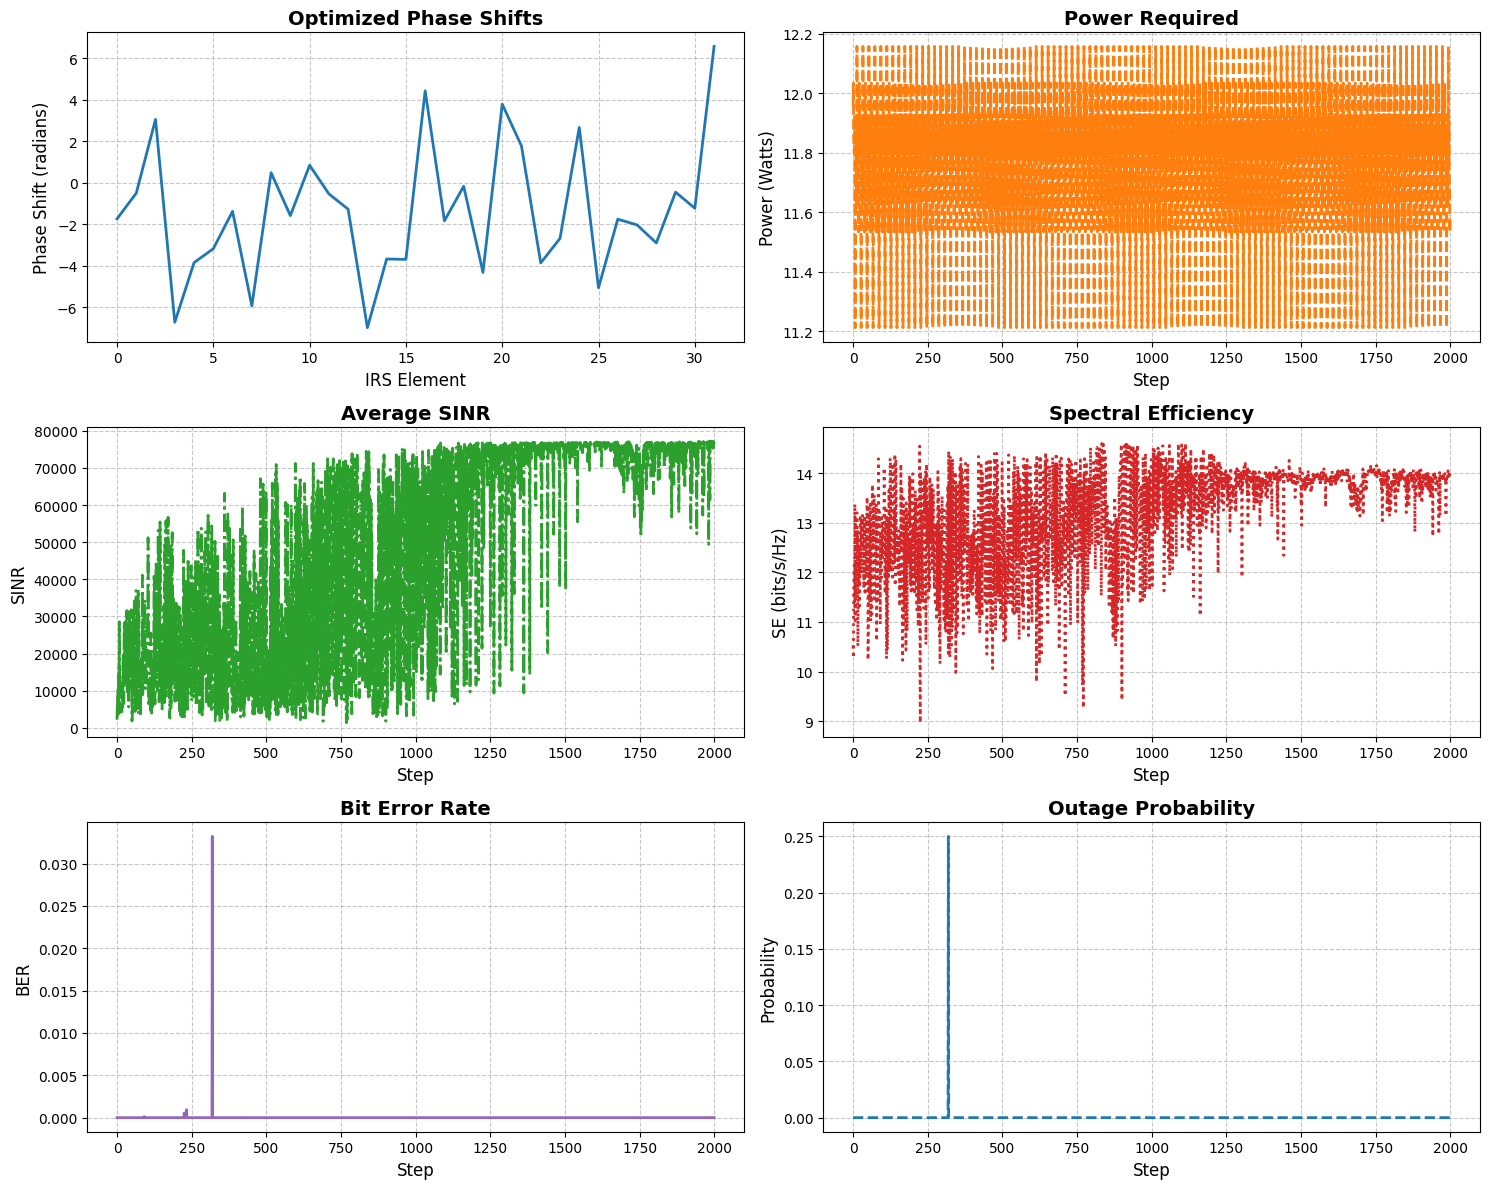

In [25]:
# prompt: Color code this PSO visualization similar to that of how the DQN visualization is done when i did it again

import numpy as np
import matplotlib.pyplot as plt

# ... (Existing code remains unchanged)


# Post-Training Analysis (Improved Visualization)
sinr_history = np.array(sinr_history)
phase_shifts_history = np.array(phase_shifts_history)

power_required = np.mean(np.abs(phase_shifts_history) ** 2, axis=1)
spectral_efficiency = np.log2(1 + sinr_history)
ber = 0.5 * np.exp(-sinr_history / 2)
outage_probability = np.mean(sinr_history < 10 ** (OUTAGE_THRESHOLD / 10), axis=1)

plt.figure(figsize=(15, 12))  # Increased figure size for better layout

# Define colors and styles
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
line_styles = ['-', '--', '-.', ':']


plt.subplot(3, 2, 1)
plt.plot(phase_shifts_history.mean(axis=0), color=colors[0], linestyle=line_styles[0], linewidth=2)
plt.title("Optimized Phase Shifts", fontsize=14, fontweight='bold')
plt.xlabel("IRS Element", fontsize=12)
plt.ylabel("Phase Shift (radians)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)


plt.subplot(3, 2, 2)
plt.plot(power_required, color=colors[1], linestyle=line_styles[1], linewidth=2)
plt.title("Power Required", fontsize=14, fontweight='bold')
plt.xlabel("Step", fontsize=12)
plt.ylabel("Power (Watts)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(3, 2, 3)
plt.plot(sinr_history.mean(axis=1), color=colors[2], linestyle=line_styles[2], linewidth=2)
plt.title("Average SINR", fontsize=14, fontweight='bold')
plt.xlabel("Step", fontsize=12)
plt.ylabel("SINR", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(3, 2, 4)
plt.plot(spectral_efficiency.mean(axis=1), color=colors[3], linestyle=line_styles[3], linewidth=2)
plt.title("Spectral Efficiency", fontsize=14, fontweight='bold')
plt.xlabel("Step", fontsize=12)
plt.ylabel("SE (bits/s/Hz)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(3, 2, 5)
plt.plot(ber.mean(axis=1), color=colors[4], linestyle=line_styles[0], linewidth=2)  # Reuse a color
plt.title("Bit Error Rate", fontsize=14, fontweight='bold')
plt.xlabel("Step", fontsize=12)
plt.ylabel("BER", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(3, 2, 6)
plt.plot(outage_probability, color=colors[0], linestyle=line_styles[1], linewidth=2)  # Reuse colors and styles
plt.title("Outage Probability", fontsize=14, fontweight='bold')
plt.xlabel("Step", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)


plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()


Episode 1, Reward: 16646347.925996142
Episode 2, Reward: 12896772.140028492
Episode 3, Reward: 15936682.38745278
Episode 4, Reward: 20041027.76257796
Episode 5, Reward: 14715549.908645598
Episode 6, Reward: 15397567.173202764
Episode 7, Reward: 20928044.25684422
Episode 8, Reward: 20922289.091784872
Episode 9, Reward: 23783705.960769307
Episode 10, Reward: 19675546.09457597
Episode 11, Reward: 18321057.339260716
Episode 12, Reward: 21051424.02977679
Episode 13, Reward: 19612296.978634484
Episode 14, Reward: 19494198.982994497
Episode 15, Reward: 21008312.323693965
Episode 16, Reward: 20365151.388393123
Episode 17, Reward: 17166162.520799953
Episode 18, Reward: 22364385.175915837
Episode 19, Reward: 20510986.284091186
Episode 20, Reward: 18053517.527169835
Episode 21, Reward: 17450610.493321422
Episode 22, Reward: 21656477.774550963
Episode 23, Reward: 18605681.953450594
Episode 24, Reward: 24458630.38140407
Episode 25, Reward: 13427848.372645577
Episode 26, Reward: 14767291.445846928
E

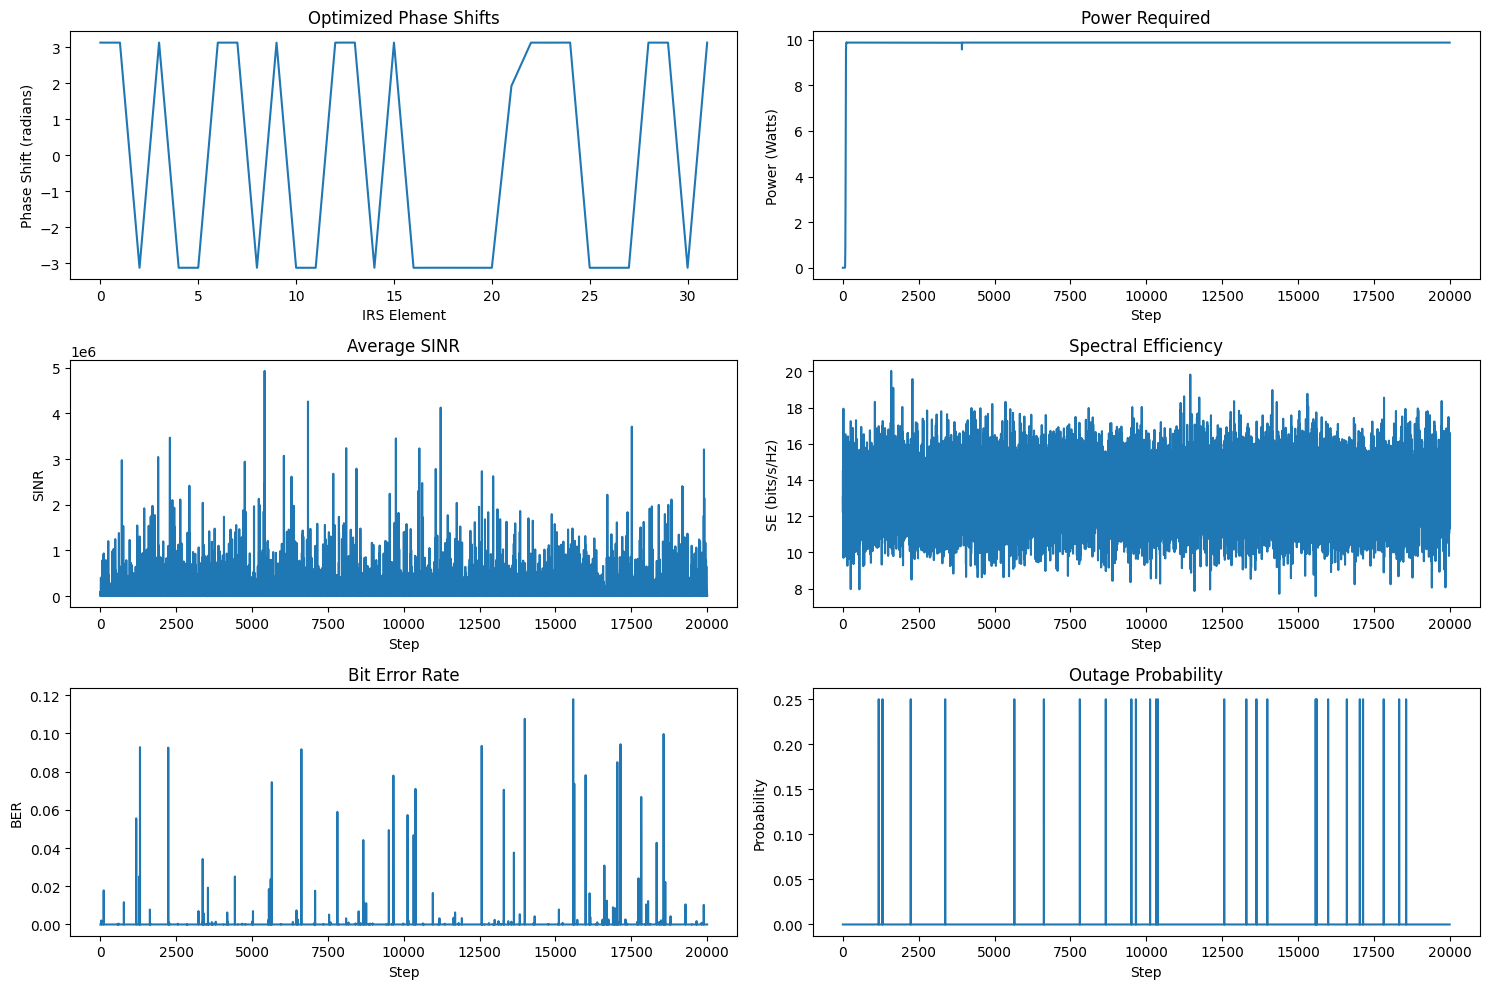

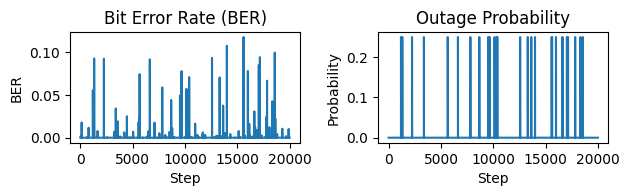


==== Model Performance Metrics ====
1. Average SINR: 97611.73 dB
2. Average Spectral Efficiency: 13.21 bits/s/Hz
3. Average Bit Error Rate (BER): 0.000121
4. Outage Probability: 0.0003
5. Average Power Consumption: 9.8243 W


In [1]:
#MY DDPG


import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random

# Environment Parameters
NUM_USERS = 4  # Number of users
NUM_IRS_ELEMENTS = 32  # Number of IRS elements
CARRIER_FREQUENCY = 28e9  # 28 GHz
WAVELENGTH = 3e8 / CARRIER_FREQUENCY
NOISE_POWER = 1e-9  # Noise power in watts
MAX_POWER = 1.0  # Maximum transmit power
BANDWIDTH = 100e6  # 100 MHz bandwidth
OUTAGE_THRESHOLD = 5  # SINR threshold for outage (in dB)

# DDPG Parameters
ACTOR_LR = 0.001
CRITIC_LR = 0.002
GAMMA = 0.99
TAU = 0.005
BUFFER_SIZE = 100000
BATCH_SIZE = 64
MAX_EPISODES = 100
MAX_STEPS = 200
# XYZ Coordinates
IRS_POSITION = np.array([0, 0, 10])  # IRS is placed at (0, 0, 10)
BS_POSITION = np.array([100, 0, 20])  # Base station is at (100, 0, 20)
USER_POSITIONS = np.random.uniform(low=[-50, -50, 0], high=[50, 50, 0], size=(NUM_USERS, 3))  # Random user positions

# Define the Actor Network
class Actor(tf.keras.Model):
    def __init__(self):
        super(Actor, self).__init__()
        self.fc1 = layers.Dense(256, activation='relu')
        self.fc2 = layers.Dense(256, activation='relu')
        self.phase_shifts = layers.Dense(NUM_IRS_ELEMENTS, activation='tanh')  # Output phase shifts

    def call(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        phase_shifts = self.phase_shifts(x) * np.pi  # Scale to [-π, π]
        return phase_shifts

# Define the Critic Network
class Critic(tf.keras.Model):
    def __init__(self):
        super(Critic, self).__init__()
        self.fc1 = layers.Dense(256, activation='relu')
        self.fc2 = layers.Dense(256, activation='relu')
        self.q_value = layers.Dense(1, activation=None)

    def call(self, state, action):
        x = tf.concat([state, action], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        q_value = self.q_value(x)
        return q_value                                                                                                                                                                                                                                       # DDPG Agent
class DDPGAgent:
    def __init__(self):
        self.actor = Actor()
        self.critic = Critic()
        self.target_actor = Actor()
        self.target_critic = Critic()

        self.actor_optimizer = tf.keras.optimizers.Adam(ACTOR_LR)
        self.critic_optimizer = tf.keras.optimizers.Adam(CRITIC_LR)

        self.replay_buffer = []
        self.update_target_networks(tau=1.0)  # Hard update

    def update_target_networks(self, tau):
        for target, source in zip(self.target_actor.variables, self.actor.variables):
            target.assign(tau * source + (1 - tau) * target)
        for target, source in zip(self.target_critic.variables, self.critic.variables):
            target.assign(tau * source + (1 - tau) * target)

    def act(self, state):
        state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        phase_shifts = self.actor(state)
        return phase_shifts.numpy()[0]

    def train(self):
        if len(self.replay_buffer) < BATCH_SIZE:
            return

        batch = random.sample(self.replay_buffer, BATCH_SIZE)
        states = tf.convert_to_tensor([b[0] for b in batch])
        actions = tf.convert_to_tensor([b[1] for b in batch])
        rewards = tf.convert_to_tensor([b[2] for b in batch], dtype=tf.float32)
        next_states = tf.convert_to_tensor([b[3] for b in batch])

        # Update Critic
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_states)
            target_q_values = self.target_critic(next_states, target_actions)
            target_q_values = rewards + GAMMA * target_q_values
            q_values = self.critic(states, actions)
            critic_loss = tf.reduce_mean(tf.square(target_q_values - q_values))
        critic_grads = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))

        # Update Actor
        with tf.GradientTape() as tape:
            actions = self.actor(states)
            actor_loss = -tf.reduce_mean(self.critic(states, actions))
        actor_grads = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))

        # Update target networks
        self.update_target_networks(TAU)
# Environment
class IRSEnvironment:
    def __init__(self):
        self.state = self.reset()

    def reset(self):
        # Random user positions
        self.user_positions = np.random.uniform(low=[-50, -50, 0], high=[50, 50, 0], size=(NUM_USERS, 3))
        # Calculate distances and channel state information (CSI)
        self.csi = self.calculate_csi()
        return np.abs(self.csi).flatten()

    def calculate_csi(self):
        # Calculate distances between IRS, BS, and users
        irs_to_users = np.linalg.norm(IRS_POSITION - self.user_positions, axis=1)
        bs_to_users = np.linalg.norm(BS_POSITION - self.user_positions, axis=1)
        irs_to_bs = np.linalg.norm(IRS_POSITION - BS_POSITION)

        # Path loss model (simplified)
        path_loss_irs_users = 1 / (irs_to_users ** 2)
        path_loss_bs_users = 1 / (bs_to_users ** 2)
        path_loss_irs_bs = 1 / (irs_to_bs ** 2)

        # Generate random phase shifts for multipath fading
        phase_shifts = np.random.rand(NUM_USERS, NUM_IRS_ELEMENTS) * 2 * np.pi
        csi = path_loss_irs_users[:, np.newaxis] * np.exp(1j * phase_shifts)
        return csi

    def step(self, phase_shifts):
        # Calculate SINR
        effective_channel = self.csi * np.exp(1j * phase_shifts)
        signal_power = np.abs(np.sum(effective_channel, axis=1)) ** 2
        interference = NOISE_POWER
        sinr = signal_power / interference

        # Calculate reward (maximize SINR)
        reward = np.mean(sinr)

        # Next state
        next_state = self.reset()
        return next_state, reward, sinr
# Training Loop
agent = DDPGAgent()
env = IRSEnvironment()
episode_rewards = []
sinr_history = []
phase_shifts_history = []

for episode in range(MAX_EPISODES):
    state = env.reset()
    total_reward = 0

    for step in range(MAX_STEPS):
        phase_shifts = agent.act(state)
        next_state, reward, sinr = env.step(phase_shifts)
        agent.replay_buffer.append((state, phase_shifts, reward, next_state))
        agent.train()
        state = next_state
        total_reward += reward

        # Store metrics
        sinr_history.append(sinr)
        phase_shifts_history.append(phase_shifts)

    episode_rewards.append(total_reward)
    print(f"Episode {episode + 1}, Reward: {total_reward}")

# Post-Training Analysis
sinr_history = np.array(sinr_history)
phase_shifts_history = np.array(phase_shifts_history)

# Calculate Power Required
power_required = np.mean(np.abs(phase_shifts_history) ** 2, axis=1)

# Calculate Spectral Efficiency (SE)
spectral_efficiency = np.log2(1 + sinr_history)

# Calculate Bit Error Rate (BER) - Approximation
ber = 0.5 * np.exp(-sinr_history / 2)

# Calculate Outage Probability
outage_probability = np.mean(sinr_history < 10 ** (OUTAGE_THRESHOLD / 10), axis=1)

# Visualization
plt.figure(figsize=(15, 10))

# Plot Phase Shifts
plt.subplot(3, 2, 1)
plt.plot(phase_shifts_history.mean(axis=0))
plt.title("Optimized Phase Shifts")
plt.xlabel("IRS Element")
plt.ylabel("Phase Shift (radians)")

# Plot Power Required
plt.subplot(3, 2, 2)
plt.plot(power_required)
plt.title("Power Required")
plt.xlabel("Step")
plt.ylabel("Power (Watts)")

# Plot SINR
plt.subplot(3, 2, 3)
plt.plot(sinr_history.mean(axis=1))
plt.title("Average SINR")
plt.xlabel("Step")
plt.ylabel("SINR")

# Plot Spectral Efficiency
plt.subplot(3, 2, 4)
plt.plot(spectral_efficiency.mean(axis=1))
plt.title("Spectral Efficiency")
plt.xlabel("Step")
plt.ylabel("SE (bits/s/Hz)")

# Plot Bit Error Rate
plt.subplot(3, 2, 5)
plt.plot(ber.mean(axis=1))
plt.title("Bit Error Rate")
plt.xlabel("Step")
plt.ylabel("BER")

# Plot Outage Probability
plt.subplot(3, 2, 6)
plt.plot(outage_probability)
plt.title("Outage Probability")
plt.xlabel("Step")
plt.ylabel("Probability")

plt.tight_layout()
plt.show()


# Complete the visualization with missing plots
plt.subplot(3, 2, 5)
plt.plot(ber.mean(axis=1))
plt.title("Bit Error Rate (BER)")
plt.xlabel("Step")
plt.ylabel("BER")

plt.subplot(3, 2, 6)
plt.plot(outage_probability)
plt.title("Outage Probability")
plt.xlabel("Step")
plt.ylabel("Probability")

plt.tight_layout()
plt.show()

# Final Efficiency Metrics Calculation
avg_sinr = np.mean(sinr_history)
avg_spectral_efficiency = np.mean(spectral_efficiency)
avg_ber = np.mean(ber)
outage_prob = np.mean(outage_probability)
avg_power = np.mean(power_required)

print("\n==== Model Performance Metrics ====")
print(f"1. Average SINR: {avg_sinr:.2f} dB")
print(f"2. Average Spectral Efficiency: {avg_spectral_efficiency:.2f} bits/s/Hz")
print(f"3. Average Bit Error Rate (BER): {avg_ber:.6f}")
print(f"4. Outage Probability: {outage_prob:.4f}")
print(f"5. Average Power Consumption: {avg_power:.4f} W")

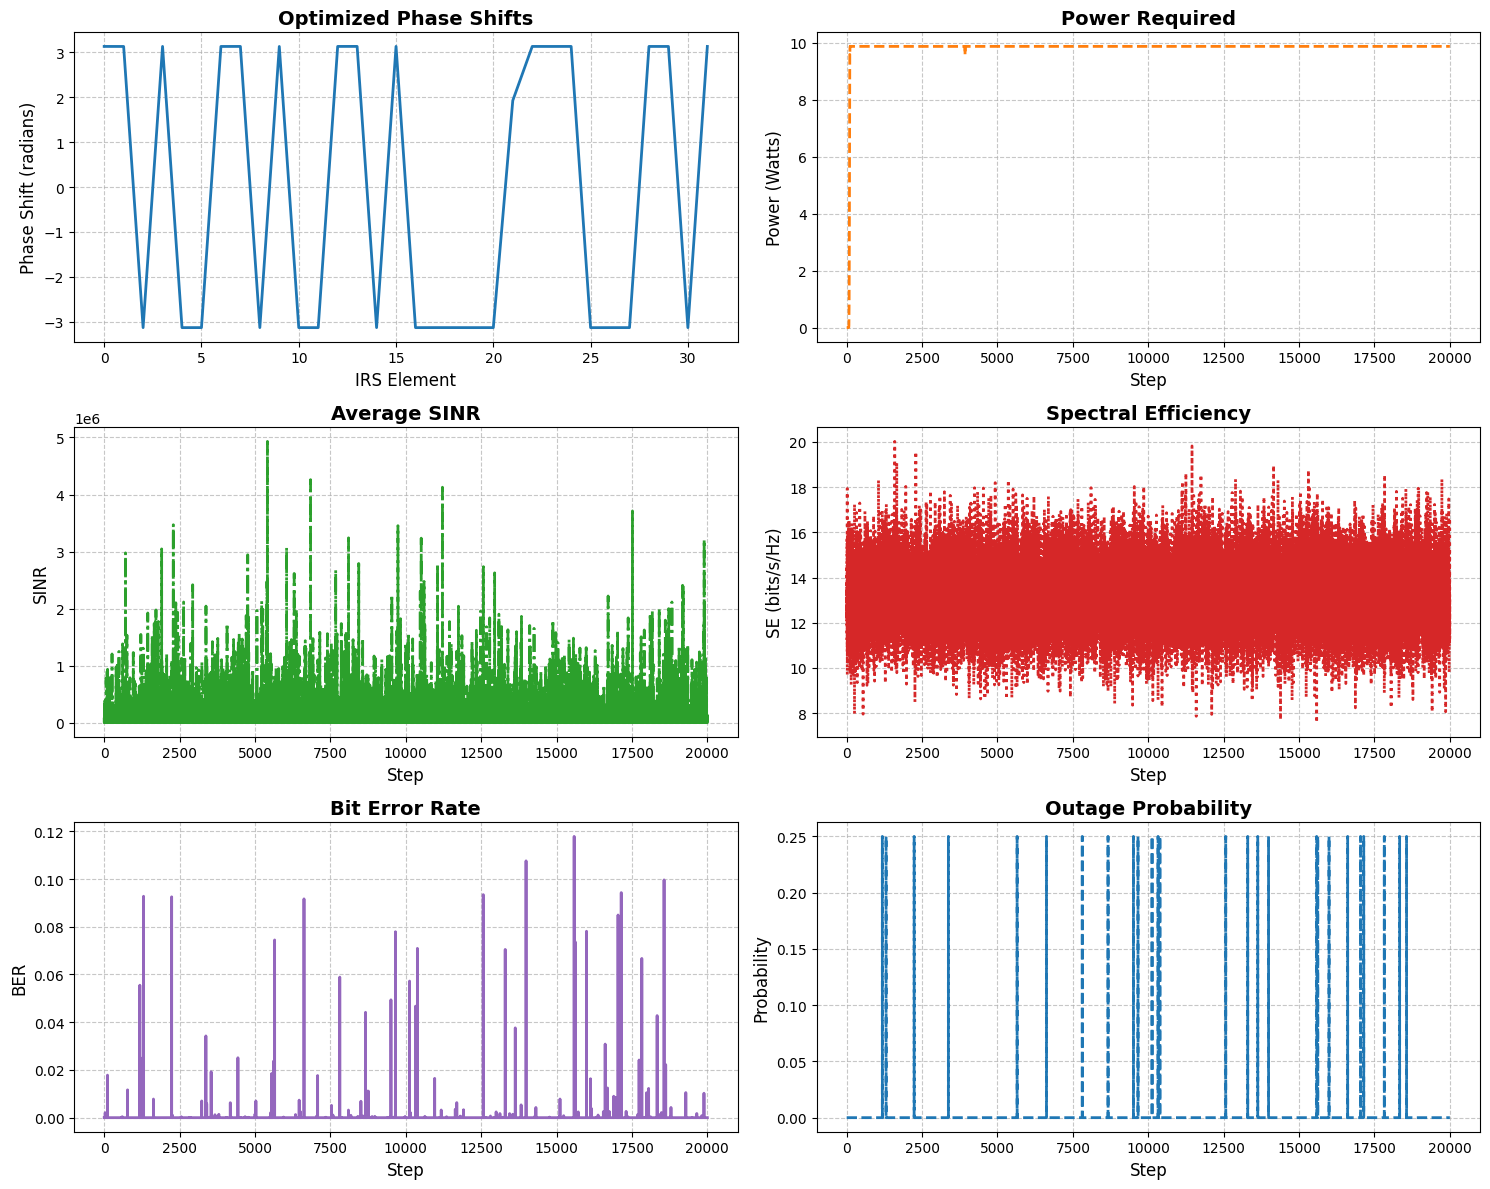

In [2]:
# prompt: Generate me the visualization with color code like in the previous 2 algorithims

# Post-Training Analysis (Improved Visualization)
sinr_history = np.array(sinr_history)
phase_shifts_history = np.array(phase_shifts_history)

power_required = np.mean(np.abs(phase_shifts_history) ** 2, axis=1)
spectral_efficiency = np.log2(1 + sinr_history)
ber = 0.5 * np.exp(-sinr_history / 2)
outage_probability = np.mean(sinr_history < 10 ** (OUTAGE_THRESHOLD / 10), axis=1)

plt.figure(figsize=(15, 12))  # Increased figure size for better layout

# Define colors and styles
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
line_styles = ['-', '--', '-.', ':']


plt.subplot(3, 2, 1)
plt.plot(phase_shifts_history.mean(axis=0), color=colors[0], linestyle=line_styles[0], linewidth=2)
plt.title("Optimized Phase Shifts", fontsize=14, fontweight='bold')
plt.xlabel("IRS Element", fontsize=12)
plt.ylabel("Phase Shift (radians)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)


plt.subplot(3, 2, 2)
plt.plot(power_required, color=colors[1], linestyle=line_styles[1], linewidth=2)
plt.title("Power Required", fontsize=14, fontweight='bold')
plt.xlabel("Step", fontsize=12)
plt.ylabel("Power (Watts)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(3, 2, 3)
plt.plot(sinr_history.mean(axis=1), color=colors[2], linestyle=line_styles[2], linewidth=2)
plt.title("Average SINR", fontsize=14, fontweight='bold')
plt.xlabel("Step", fontsize=12)
plt.ylabel("SINR", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(3, 2, 4)
plt.plot(spectral_efficiency.mean(axis=1), color=colors[3], linestyle=line_styles[3], linewidth=2)
plt.title("Spectral Efficiency", fontsize=14, fontweight='bold')
plt.xlabel("Step", fontsize=12)
plt.ylabel("SE (bits/s/Hz)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(3, 2, 5)
plt.plot(ber.mean(axis=1), color=colors[4], linestyle=line_styles[0], linewidth=2)  # Reuse a color
plt.title("Bit Error Rate", fontsize=14, fontweight='bold')
plt.xlabel("Step", fontsize=12)
plt.ylabel("BER", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(3, 2, 6)
plt.plot(outage_probability, color=colors[0], linestyle=line_styles[1], linewidth=2)  # Reuse colors and styles
plt.title("Outage Probability", fontsize=14, fontweight='bold')
plt.xlabel("Step", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)


plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()
